<a href="https://colab.research.google.com/github/manish2021iitd/Deep-Learning/blob/main/DLassignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

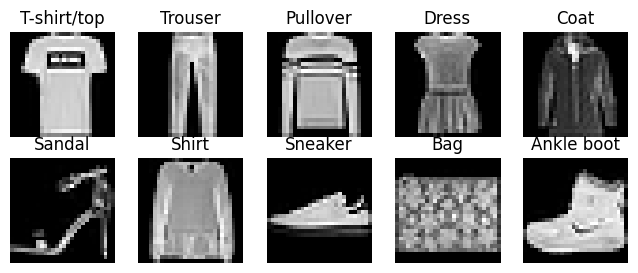

In [25]:
#Q1 wa
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(training_images, training_labels), (testing_images,testing_labels) = fashion_mnist.load_data()

# Plot one sample image for each class
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(training_images[training_labels == i][0], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.show()


In [26]:
#Q2
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size #number of inputs nodes
        self.hidden_sizes = hidden_sizes #list of neurons in each hidden layer
        self.output_size = output_size #number of output neurons in output layer
        self.weights = [] #list of weight matrices for each layer
        self.biases = []  #list of bias vectors for each hidden layer and output layer

        #innitializing the weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size] #using list concatination to make a list of number of nodes in each layer
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i+1], sizes[i]))
            self.biases.append(np.random.randn(sizes[i+1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
      # Forward pass
      activations = [X]
      for i in range(len(self.weights)):
        z = np.dot(activations[-1], self.weights[i].T) + self.biases[i]  # Transpose weight matrix
        a = self.sigmoid(z) if i < len(self.weights) - 1 else self.softmax(z)
        activations.append(a)
      return activations

    def predict(self, X):
        #predict output probabilities
        activations = self.forward(X)
        return activations[-1]

#load fashion-mnist dataset
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#define neural network
input_size = X_train.shape[1]  #28x28 images flattened
hidden_sizes = [128, 64]  #size of hidden layers
output_size = 10  # 10 classes in fashion-mnist

#initialize neural network
model = NeuralNetwork(input_size, hidden_sizes, output_size)

#predict probabilities for the test set
probabilities = model.predict(X_test)

#print the output probabilities
print("Output Probabilities:", probabilities)

Output Probabilities: [[1.04475834e-04 1.44642151e-05 2.43624327e-03 ... 3.49854295e-08
  9.97124343e-01 3.96608533e-05]
 [7.39678750e-03 3.30634783e-02 1.95380702e-03 ... 2.41844295e-07
  9.52045298e-01 5.49484087e-03]
 [1.71436904e-04 1.42051972e-03 8.14867927e-03 ... 3.66540565e-07
  9.89413657e-01 7.72300272e-04]
 ...
 [3.51420841e-02 1.25994062e-03 9.06393166e-02 ... 2.34495568e-05
  8.71912272e-01 7.40223862e-04]
 [1.48253774e-03 4.96426559e-06 1.92739278e-03 ... 2.78860593e-08
  9.96529403e-01 5.55794582e-05]
 [9.21448195e-06 7.82454107e-05 3.13586749e-04 ... 2.82851649e-08
  9.99451925e-01 4.33512501e-05]]


In [27]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.dw = []
        self.db = []
        self.delta = []

        #initialize weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i+1]))
            self.biases.append(np.random.randn(sizes[i+1], 1))
        #initialize velocities for momentum-based optimization
        self.velocities = [np.zeros_like(w) for w in self.weights]

        #initialize rmsprop parameters
        self.rmsprop_cache_w = [np.zeros_like(w) for w in self.weights]
        self.rmsprop_cache_b = [np.zeros_like(b) for b in self.biases]

        #initialize adam parameters
        self.adam_m_w = [np.zeros_like(w) for w in self.weights]
        self.adam_m_b = [np.zeros_like(b) for b in self.biases]
        self.adam_v_w = [np.zeros_like(w) for w in self.weights]
        self.adam_v_b = [np.zeros_like(b) for b in self.biases]

    @staticmethod
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))

    @staticmethod
    def relu(x):
      return (x>0)*(x)

    @staticmethod
    def tanh(x):
      return np.tanh(x)

    def activation_fun(self,x, act_fun):
      if act_fun == 'sigmoid':
        return NeuralNetwork.sigmoid(x)
      elif act_fun == 'tanh':
        return NeuralNetwork.tanh(x)
      elif act_fun == 'relu':
        return NeuralNetwork.relu(x)

    def der_activation(self,x,act_fun):
      if act_fun == 'sigmoid':
        return NeuralNetwork.sigmoid(x)*(1-NeuralNetwork.sigmoid(x))
      elif act_fun == 'tanh':
        return 1 - NeuralNetwork.tanh(x) * NeuralNetwork.tanh(x)
      elif act_fun == 'relu':
        return np.where(x <= 0, 0, 1)

    def softmax(self,x):
      exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
      return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def softmax_derivative(self,x):
      softmax_output = self.softmax(x)
      return softmax_output * (1 - softmax_output)

    @staticmethod
    def logloss(y, y_label):
      error = -(y_label*np.log(y+1e-10)+(1-y_label)*np.log(1-y+1e-10))
      return np.sum(error, axis = 0)/error.shape[0]

    @staticmethod
    def Cross_entropy(y, y_hat):
      da = (1-y)/(1-y_hat) - (y)/(y_hat+1e-10)
      epoch_loss = logloss(y_hat, y)
      return da, epoch_loss

    #forwardpropagation
    def forward(self, X, act_fun):
      self.activations = [] #create a list of all activations
      self.preactivations = []
      self.activations.append(X)
      self.preactivations.append(X)
      for i in range(len(self.weights)):
        z = np.dot(self.weights[i].T,self.activations[-1]) + self.biases[i]
        self.preactivations.append(z)  #preactivation
        if i < len(self.weights) - 1:
          a = self.activation_fun(z,act_fun)
        else:
          a = self.softmax(z) #output function
        #print("activation:",i,a.shape)
        self.activations.append(a) #appending the activations list
      return self.activations , self.preactivations

    #backwardpropagation
    def backward(self, y,act_fun):

        self.dw = []
        self.db = []
        self.delta = []
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                dz = (self.activations[-1] - y.T)
            else:
                dz = np.dot(self.weights[i+1],self.delta[-1]) *  self.der_activation(self.preactivations[i+1],act_fun)
            self.delta.append(dz)
            dw_temp = np.dot(dz,self.activations[i].T)
            self.dw.append(dw_temp)
            db_temp = np.sum(dz, axis=0)
            self.db.append(db_temp)

        self.dw.reverse()
        self.db.reverse()
        return self.dw, self.db

    def update(self, X, y,act_fun, optimizer, epochs, learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):
      for _ in range(epochs):
        activations = self.forward(X,act_fun)
        #print(activations)
        dw, db = self.backward(y,act_fun)
        #print(dw)
        #print(db)
        if optimizer == 'sgd':
          for i in range(len(self.weights)):
            #print(dw[i].shape)
            #print(self.weights[i].shape)
            self.weights[i] -= learning_rate * dw[i].T
            #print(self.biases[i].shape)
            #print(db[i].shape)
            self.biases[i] -= learning_rate * np.mean(db[i], axis=0, keepdims=True)

        elif optimizer == 'momentum':
          for i in range(len(self.weights)):
            self.velocities[i] = beta1 * self.velocities[i] + (1 - beta1) * dw[i].T
            self.weights[i] -= learning_rate * self.velocities[i]
            self.biases[i] -= learning_rate * np.mean(db[i], axis=0, keepdims=True)


        elif optimizer == 'nesterov':
          lookahead_weights = [w - beta1 * v for w, v in zip(self.weights, self.velocities)]
          lookahead_biases = [b - beta1 * v[-1] for b, v in zip(self.biases, self.velocities)]
          lookahead_activations = self.forward(X,act_fun)
          lookahead_dw, lookahead_db = self.backward(y, lookahead_activations)
          for i in range(len(self.weights)):
            self.velocities[i] = beta1 * self.velocities[i] + (1 - beta1) * lookahead_dw[i].T
            self.weights[i] -= learning_rate * self.velocities[i]
            self.biases[i] -= learning_rate * np.mean(lookahead_db[i], axis=0, keepdims=True)

        elif optimizer == 'rmsprop':
          for i in range(len(self.weights)):
            self.rmsprop_cache_w[i] = beta1 * self.rmsprop_cache_w[i] + (1 - beta1) * (dw[i].T)**2
            self.rmsprop_cache_b[i] = beta1 * self.rmsprop_cache_b[i] + (1 - beta1) * np.mean(db[i], axis=0, keepdims=True)**2
            self.weights[i] -= learning_rate * dw[i].T / (np.sqrt(self.rmsprop_cache_w[i]) + epsilon)
            self.biases[i] -= learning_rate * np.mean(db[i], axis=0, keepdims=True) / (np.sqrt(self.rmsprop_cache_b[i]) + epsilon)

        elif optimizer == 'adam':
          for i in range(len(self.weights)):
            self.adam_m_w[i] = beta1 * self.adam_m_w[i] + (1 - beta1) * dw[i].T
            self.adam_m_b[i] = beta1 * self.adam_m_b[i] + (1 - beta1) * np.mean(db[i], axis=0, keepdims=True)
            self.adam_v_w[i] = beta2 * self.adam_v_w[i] + (1 - beta2) * (dw[i].T)**2
            self.adam_v_b[i] = beta2 * self.adam_v_b[i] + (1 - beta2) * np.mean(db[i], axis=0, keepdims=True)**2
            m_w_hat = self.adam_m_w[i] / (1 - beta1**(i+1))
            m_b_hat = self.adam_m_b[i] / (1 - beta1**(i+1))
            v_w_hat = self.adam_v_w[i] / (1 - beta2**(i+1))
            v_b_hat = self.adam_v_b[i] / (1 - beta2**(i+1))
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

        elif optimizer == 'nadam':
          for i in range(len(self.weights)):
            self.adam_m_w[i] = beta1 * self.adam_m_w[i] + (1 - beta1) * dw[i].T
            self.adam_m_b[i] = beta1 * self.adam_m_b[i] + (1 - beta1) * np.mean(db[i], axis=0, keepdims=True)
            self.adam_v_w[i] = beta2 * self.adam_v_w[i] + (1 - beta2) * dw[i].T**2
            self.adam_v_b[i] = beta2 * self.adam_v_b[i] + (1 - beta2) * np.mean(db[i], axis=0, keepdims=True)**2
            m_w_hat = self.adam_m_w[i] / (1 - beta1**(i+1))
            m_b_hat = self.adam_m_b[i] / (1 - beta1**(i+1))
            v_w_hat = self.adam_v_w[i] / (1 - beta2**(i+1))
            v_b_hat = self.adam_v_b[i] / (1 - beta2**(i+1))
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)


    def train(self, X, y,act_fun, optimizer, epochs, batch_size,learning_rate):
      #train the neural network using different optimizers
      for i in range(0, len(X), batch_size):
        X_batch = X[:,i:i+batch_size]
        #print("X_batch:",X_batch.shape)
        y_batch = y[i:i+batch_size]
        #print("y_batch:",y_batch.shape)
        self.update(X_batch,y_batch,act_fun,optimizer,epochs,learning_rate)

    def test(self, X,act_fun):
      a,b = self.forward(X,act_fun)
      return a[-1]


#load fashion-mnist dataset
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
#print('X_tain:',X_train.shape)
#print("X_test:",X_test.shape)
X_train = X_train.T
#print("X_tain.T:",X_train.shape)


#define neural network
input_size = 784#size of inputs
hidden_sizes = [128]  #size of neurons in each hidden layers
output_size = 10  #taking 10 output neurons as we have classify 10 classes in fashion-mnist

#convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]
#print("y_train_one_hot:",y_train_one_hot.shape)
#print("y_test_one_hot:",y_test_one_hot.shape)

#initialize neural network
model = NeuralNetwork(input_size, hidden_sizes, output_size)

'''please choose act_fun= 'sigmoid'/'relu'/'tanh' ,optimizer = 'sgd'/'momentum'/'nesterov'/'rmsprop'/'adam'/'nadam'
and number of epochs and batch size here'''
model.train(X_train, y_train_one_hot,'sigmoid','sgd', epochs=5, batch_size=32,learning_rate=0.01)

results = model.test(X_test.T,'sigmoid')

results = np.argmax(results.T, axis=1)

real_labels = np.argmax(y_test_one_hot, axis=1)
#print(real_labels.shape)
accuracy = sum(1*(results==real_labels))/len(results)
#accuracy = np.mean(results==real_labels)
print("The accuracy of testing is ", accuracy*100, "%")
#References:
#1.https://cs229.stanford.edu/main_notes.pdf
#2.http://www.cse.iitm.ac.in/~miteshk/CS6910.html
#3.https://visualstudiomagazine.com/Articles/2017/06/01/Back-Propagation.aspx?Page=2
#4.https://medium.com/@ipylypenko/exploring-neural-networks-with-fashion-mnist-b0a8214b7b7b
#5.https://www.youtube.com/watch?v=Wo5dMEP_BbI&list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
#7.https://www.youtube.com/watch?v=LQvRhQwDOm0

The accuracy of testing is  56.279999999999994 %


In [28]:
!pip install wandb

In [29]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [30]:
wandb.login(key='e3c892d4f8c9cd9b9043d31938ad090f0a32cec1')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
# You need to define a config file in the form of dictionary or yaml
sweep_config = {
    'method': 'random',
    'name' : 'sweep cross entropy',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
         'hidden_sizes':{
            'values':[32,64,128]
        },
        'activation': {
            'values': ['sigmoid','relu','tanh']
        },
        'loss': {
            'values': ['cross_entropy']
        },
        'weight_decay':{
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate':{
            'values':[0.0001, 0.00001]
        },
        'optimizer': {
            'values':['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size':{
             'values':[16, 32, 64]
        },
        'weight_initialisation':{
             'values':['random', 'Xavier']
        },

    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DLassignment1')

Create sweep with ID: qhwxpeiq
Sweep URL: https://wandb.ai/ma23m010/DLassignment1/sweeps/qhwxpeiq


In [34]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''


    with wandb.init() as run:

        run_name="-ep" + str(wandb.config.epochs) + "-hs" + str(wandb.config.hidden_sizes) + "-as" + str(wandb.config.activation) + "-ls" + str(wandb.config.loss)
        + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
        +"-wi"+str(wandb.config.weight_initialisation) + wandb.run.name==run_name
        #obj=NN(wandb.config['num_layers'],wandb.config['hidden_size'])
        model = NeuralNetwork(input_size, wandb.config.hidden_sizes, output_size)

        #criterion = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(model.parameters(), lr=0.01,betas=(0.9, 0.999))
        model.train(X_train, y_train_one_hot,wandb.config.activation,wandb.config.optimizer, wandb.config.epochs, wandb.config.batch_size,wandb.config.learning_rate)

wandb.agent(sweep_id, function=main,count=10) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: 6y2fprbl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: Xavier


Traceback (most recent call last):
  File "<ipython-input-34-5a66dd829ad1>", line 13, in main
    + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
TypeError: bad operand type for unary +: 'str'


Run 6y2fprbl errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "<ipython-input-34-5a66dd829ad1>", line 13, in main
    + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
TypeError: bad operand type for unary +: 'str'

wandb: ERROR Run 6y2fprbl errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-34-5a66dd829ad1>", line 13, in main
wandb: ERROR     + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
wandb: ERROR TypeError: bad operand type for unary +: 'str'
wandb: ERROR 
wandb: Agent Startin

Traceback (most recent call last):
  File "<ipython-input-34-5a66dd829ad1>", line 13, in main
    + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
TypeError: bad operand type for unary +: 'str'


Run ocimztjj errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "<ipython-input-34-5a66dd829ad1>", line 13, in main
    + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
TypeError: bad operand type for unary +: 'str'

wandb: ERROR Run ocimztjj errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-34-5a66dd829ad1>", line 13, in main
wandb: ERROR     + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
wandb: ERROR TypeError: bad operand type for unary +: 'str'
wandb: ERROR 
wandb: Agent Startin

Traceback (most recent call last):
  File "<ipython-input-34-5a66dd829ad1>", line 13, in main
    + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
TypeError: bad operand type for unary +: 'str'


Run 07rptxud errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "<ipython-input-34-5a66dd829ad1>", line 13, in main
    + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
TypeError: bad operand type for unary +: 'str'

wandb: ERROR Run 07rptxud errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-34-5a66dd829ad1>", line 13, in main
wandb: ERROR     + "-wd"+str(wandb.config.weight_decay) + "-lr" + str(wandb.config.learning_rate) + "-op" + wandb.config.optimizer + "-bs" + str(wandb.config.batch_size)
wandb: ERROR TypeError: bad operand type for unary +: 'str'
wandb: ERROR 
Detected 3 failed ru